In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import stats
import tqdm
import seaborn as sns


source_all = pd.read_csv('../../data/source_all.csv')
thre = 0.1  # {0.1,0.2}
poli_range = [-2,-thre, thre-0.00000001,2]
suffix = str(thre)
i2poli = source_all[source_all['manual']<90]
i2poli = i2poli[['i','manual']]
i2poli.rename(columns={'manual':'poli'},inplace=True)

i2poli, source_all = i2poli.set_index('i'), source_all.set_index('i')
with open('../get_effect/result/mind/policy_effect_o2j.pkl', 'rb') as file:
    peo2j = pickle.load(file)
news = pd.read_csv('../../data/all_news.csv').set_index('i')

subcategory_list = list(news['subcategory'])
subcate_dict = {}
for subcate in subcategory_list:
    try:
        subcate_dict[subcate] += 1
    except:
        subcate_dict[subcate] = 1
subcate_arr, count_arr = np.array(list(subcate_dict.keys())), np.array(list(subcate_dict.values()))

In [2]:
ave_effect_arr, left_list, right_list, mid_list = np.zeros((28,3)), [], [], []
for a, cate in enumerate(subcate_arr):
    for b in [0,1,2]:
        v_effect, count = [], 0
        for j in peo2j:
            if j not in i2poli.index or i2poli.loc[j,'poli'] <= poli_range[b] or i2poli.loc[j,'poli'] > poli_range[b+1] or source_all.loc[j,'click']<1:
                continue
            for v in peo2j[j]:
                if v not in news.index or news.loc[v,'subcategory']!= cate:
                    continue
                v_effect.append(peo2j[j][v])
                count += 1
        if len(v_effect) != 0:
            ave_effect_arr[a,b] = np.mean(v_effect)
        else:
            ave_effect_arr[a,b] = 0
        if b==0:
            left_list.extend(v_effect)
        elif b==2:
            right_list.extend(v_effect)
        else:
            mid_list.extend(v_effect)

***** Wilcoxon-Mann-Whitney test *****
pval_left_right 1.0584072026737945e-14
pval_left_mid 0.9999183928681178
pval_mid_right 9.711780488117707e-20
0.0021045407275087024 0.0028477625735970676 0.00047502232612604064


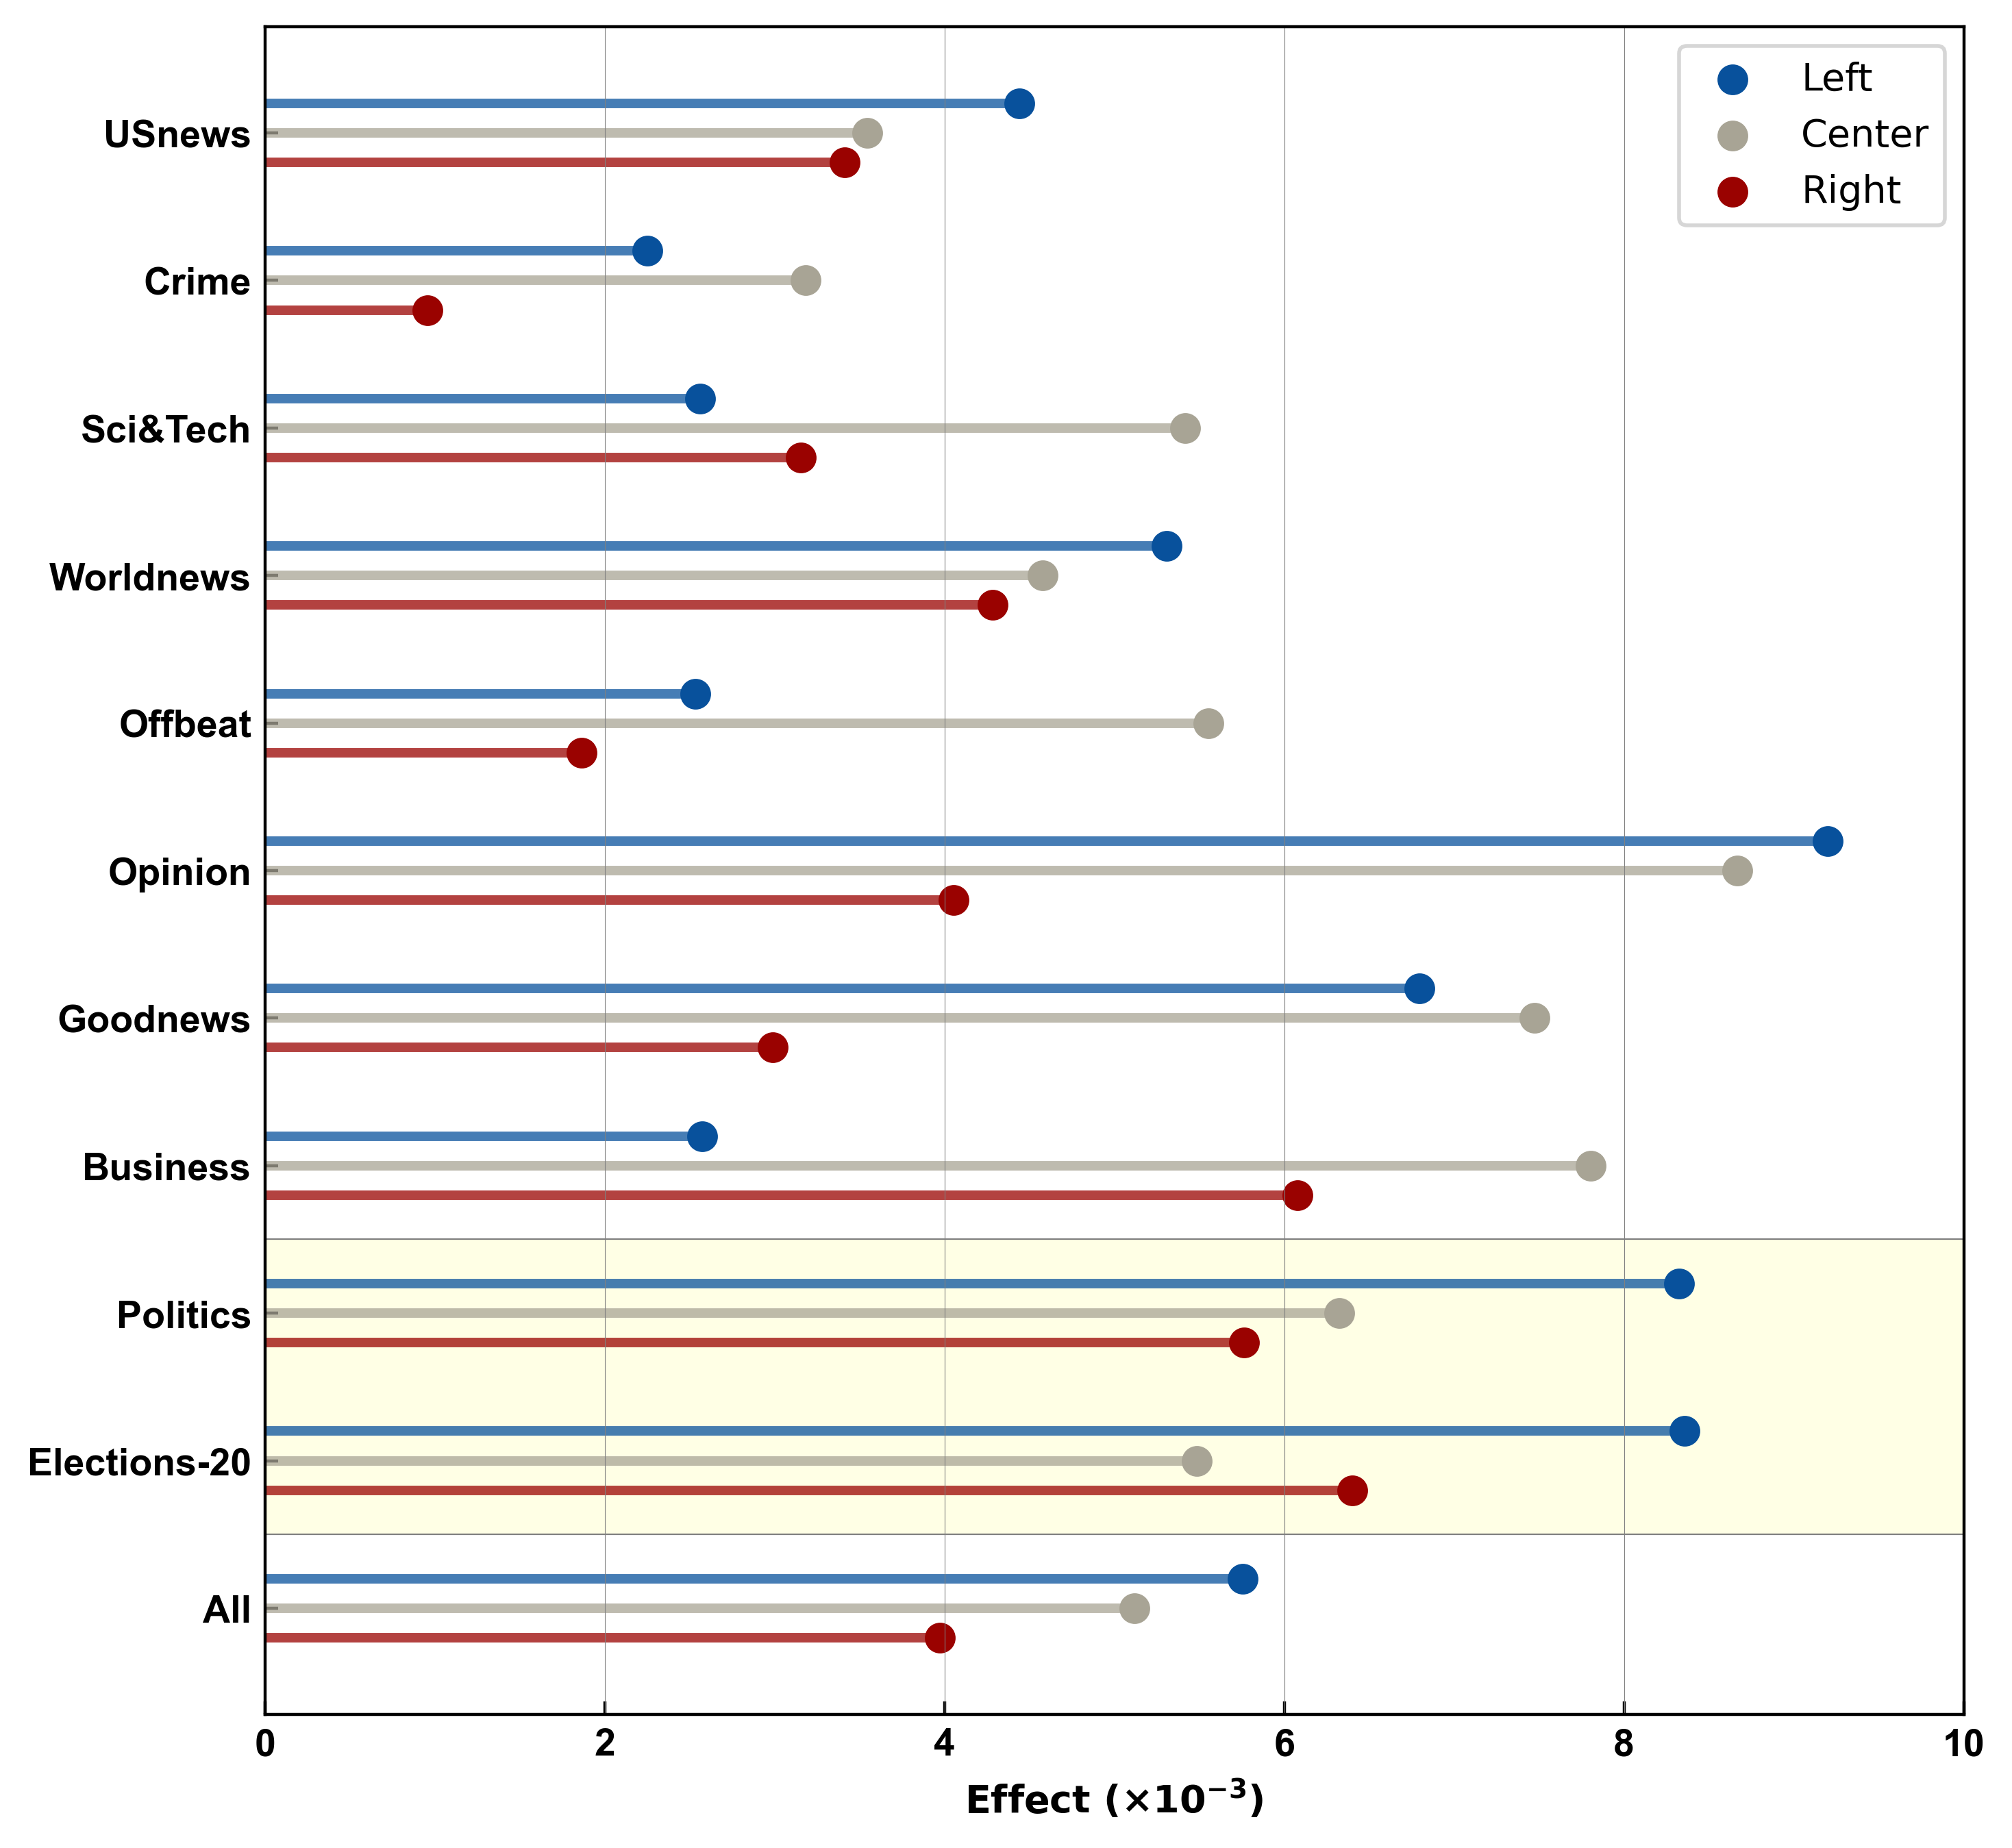

In [3]:
print('***** Wilcoxon-Mann-Whitney test *****')
pval_left_right = tuple(stats.mannwhitneyu(left_list, right_list, alternative='greater'))[1]
print('pval_left_right',pval_left_right)
pval_left_mid = tuple(stats.mannwhitneyu(left_list, mid_list, alternative='greater'))[1]
print('pval_left_mid',pval_left_mid)
pval_mid_right = tuple(stats.mannwhitneyu(mid_list, right_list, alternative='greater'))[1]
print('pval_mid_right',pval_mid_right)
print(np.median(left_list),np.median(mid_list),np.median(right_list))

fig, ax = plt.subplots(figsize=(8,8),dpi=400)
rearranged_indices = [3,8,0,1,2,4,5,6,7,9]
ax.axhspan(0.5,2.5,facecolor='yellow',alpha=0.1)

k = 10
sorted_indices = np.argsort(count_arr)[-k:]
left_effect_arr = ave_effect_arr[sorted_indices,0][rearranged_indices]
ax.hlines(y=[i+1.2 for i in range(k)], xmin=0, xmax=left_effect_arr, color='#08519c', alpha=0.75, ls='-', lw=2.5)
ax.scatter(left_effect_arr, [i+1.2 for i in range(k)], color='#08519c', s=50, alpha=1, label='Left')

mid_effect_arr = ave_effect_arr[sorted_indices,1][rearranged_indices]
ax.hlines(y=[i+1 for i in range(k)], xmin=0, xmax=mid_effect_arr, color='#a8a495', alpha=0.75, ls='-', lw=2.5)
ax.scatter(mid_effect_arr, [i+1 for i in range(k)], color='#a8a495', s=50, alpha=1, label='Center')

right_effect_arr = ave_effect_arr[sorted_indices,2][rearranged_indices]
for i in range(len(right_effect_arr)):
    if right_effect_arr[i] < 0:
        right_effect_arr[i] = right_effect_arr[i] / 5
ax.hlines(y=[i+0.8 for i in range(k)], xmin=0, xmax=right_effect_arr, color='#9a0200', alpha=0.75, ls='-', lw=2.5)
ax.scatter(right_effect_arr, [i+0.8 for i in range(k)], color='#9a0200', s=50, alpha=1, label='Right')
ax.legend(loc='upper right')

ax.hlines(y=0.2, xmin=0, xmax=np.mean(left_list), color='#08519c', alpha=0.75, ls='-', lw=2.5)
ax.scatter(np.mean(left_list), 0.2, color='#08519c', s=50, alpha=1)
ax.hlines(y=0, xmin=0, xmax=np.mean(mid_list), color='#a8a495', alpha=0.75, ls='-', lw=2.5)
ax.scatter(np.mean(mid_list), 0, color='#a8a495', s=50, alpha=1)
ax.hlines(y=-0.2, xmin=0, xmax=np.mean(right_list), color='#9a0200', alpha=0.75, ls='-', lw=2.5)
ax.scatter(np.mean(right_list), -0.2, color='#9a0200', s=50, alpha=1)

if poli_range[1] == -0.2:
    ax.set_xlim((-0.002,0.01))
    ax.set_xticks([-0.002,0,0.002,0.004,0.006,0.008,0.01],labels=['-10','0','2','4','6','8','10'])
    ax.hlines(y=0.5, xmin=-0.002, xmax=0.01, color='grey', ls='-', lw=0.4)
    ax.hlines(y=2.5, xmin=-0.002, xmax=0.01, color='grey', ls='-', lw=0.4)
    for x in [0,0.002,0.004,0.006,0.008]:
        plt.axvline(x=x, c="grey", ls="-", lw=0.2)
    plt.axvline(x=0, c="grey", ls="-", lw=0.4)
else:
    ax.set_xlim((0,0.01))
    ax.set_xticks([0,0.002,0.004,0.006,0.008,0.01],labels=['0','2','4','6','8','10'])
    ax.hlines(y=0.5, xmin=0, xmax=0.01, color='grey', ls='-', lw=0.4)
    ax.hlines(y=2.5, xmin=0, xmax=0.01, color='grey', ls='-', lw=0.4)
    for x in [0.002,0.004,0.006,0.008]:
        plt.axvline(x=x, c="grey", ls="-", lw=0.2)
    # plt.axvline(x=0, c="grey", ls="-", lw=0.4)

ax.set_yticks([i for i in range(k+1)], ['All']+list(np.array(['Business', 'Goodnews', 'Opinion', 'Elections-20', 'Offbeat', 'Worldnews', 'Sci&Tech', 'Crime', 'Politics', 'USnews'])[np.array(rearranged_indices)]))
ax.set_xlabel(r'Effect $\mathbf{(\times 10^{-3})}$', weight='bold')
plt.yticks(fontproperties='Arial', size=10, weight='bold')
plt.xticks(fontproperties='Arial', size=10, weight='bold')
plt.tick_params(direction='in')

if poli_range[1] == -0.2:
    plt.savefig('./figures/news_subcate_vs_lcr_{}_S5B.pdf'.format(suffix), dpi=400,bbox_inches='tight',pad_inches=0)
else:
    plt.savefig('./figures/news_subcate_vs_lcr_{}_2B.pdf'.format(suffix), dpi=400,bbox_inches='tight',pad_inches=0)
plt.show()